In [6]:
import sys, os, pickle
from importlib import reload
from tqdm import tqdm, trange

import numpy as np, pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import SymLogNorm, LogNorm

import agama 
agama.setUnits(mass=1, length=1, velocity=1) #Msol, kpc, km/s. Time is in kpc/(kms/s)
# agama.setNumThreads(48)  

# sys.path.insert(1, '/mnt/d/Research/')
# import compute_characteristics_ut as cc

sys.path.append('../scripts/')
import stream_sim_funcs as ssf

# plt.style.use('dark_background')
%matplotlib inline

ModuleNotFoundError: No module named 'stream_sim_funcs'

# <span style="color:blue"> Agama MW-LMC </span>

In [38]:
# AGAMA like MW-LMC Potential
# Create a simple but realistic model of the Milky Way with a bulge, a single disk,
# and a spherical dark halo
paramBulge = dict(
    type              = 'Spheroid',
    mass              = 1.2e10,
    scaleRadius       = 0.2,
    outerCutoffRadius = 1.8,
    gamma             = 0.0,
    beta              = 1.8)
paramDisk  = dict(
    type='MiyamotoNagai',
    mass              = 5.0e10,
    scaleRadius       = 3.0,
    scaleHeight       = 0.3)
paramHalo  = dict(
    type              = 'Spheroid',
    densityNorm       = 1.35e7,
    scaleRadius       = 14,
    outerCutoffRadius = 300,
    cutoffStrength    = 4,
    gamma             = 1,
    beta              = 3)

densMWhalo = agama.Density(paramHalo)
potMW      = agama.Potential(paramBulge, paramDisk, paramHalo)

# Create the LMC potential - a spherical truncated NFW profile with mass and radius
# related by the equation below, which produces approximately the same enclosed mass
# profile in the inner region, satisfying the observational constraints, as shown
# in Fig.3 of Vasiliev,Belokurov&Erkal 2021.
massLMC    = 1.5e11
radiusLMC  = (massLMC/1e11)**0.6 * 8.5
bminCouLog = radiusLMC * 2.0   # minimum impact parameter in the Coulomb logarithm
potLMC     = agama.Potential(
    type              = 'spheroid',
    mass              = massLMC,
    scaleradius       = radiusLMC,
    outercutoffradius = radiusLMC*10,
    gamma             = 1,
    beta              = 3)


# Define file paths
BASE_POT_PATH = 'MW_LMC_pot/'
accMW_path = os.path.join(BASE_POT_PATH, 'accMW')
trajLMC_path = os.path.join(BASE_POT_PATH, 'trajLMC')

# Check if saved files exist
files_exist = os.path.exists(accMW_path) and os.path.exists(trajLMC_path)

if files_exist:
    try:
        print('Loading precomputed MW-LMC potential files...')
        accMW = np.loadtxt(accMW_path)
        trajLMC = np.loadtxt(trajLMC_path)
        potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
        potLMCm = agama.Potential(potential=potLMC, center=trajLMC)
        potTotal= agama.Potential(potMW, potLMCm, potacc)
        print('Successfully loaded MW-LMC potential.')
    except Exception as e:
        print(f'Error loading files: {e}')
        print('Will recompute...')
        files_exist = False

if not files_exist:
    print('Computing the MW-LMC potential from scratch...')
    
    import scipy.integrate, scipy.ndimage, scipy.special
    Trewind = -4.0  # initial time [Gyr] - the LMC orbit is computed back to that time
    Tcurr   =  0.0  # current time
    # heliocentric ICRS celestial coordinates and velocity of the LMC
    # (PM from Luri+ 2021, distance from Pietrzynski+ 2019, center and velocity from van der Marel+ 2002)
    ra, dec, dist, pmra, pmdec, vlos = 81.28, -69.78, 49.6, 1.858, 0.385, 262.2
    # transform to Galactocentric cartesian position/velocity, using built-in routines from Agama
    # (hence the manual conversion factors from degrees to radians and from mas/yr to km/s/kpc)
    l, b, pml, pmb = agama.transformCelestialCoords(agama.fromICRStoGalactic,
        ra * np.pi/180, dec * np.pi/180, pmra, pmdec)
    posvelLMC = agama.getGalactocentricFromGalactic(l, b, dist, pml*4.74, pmb*4.74, vlos)
    
    # create a sphericalized MW potential and a corresponding isotropic halo distribution function
    potMWsph   = agama.Potential(type='Multipole', potential=potMW, lmax=0, rmin=0.01, rmax=1000)
    gmHalo     = agama.GalaxyModel(potMWsph,
        agama.DistributionFunction(type='quasispherical', density=densMWhalo, potential=potMWsph))
    
    # compute the velocity dispersion in the MW halo needed for the dynamical friction
    rgrid      = np.logspace(1, 3, 16)
    xyzgrid    = np.column_stack([rgrid, rgrid*0, rgrid*0])
    sigmafnc   = agama.Spline(rgrid, gmHalo.moments(xyzgrid, dens=False, vel=False, vel2=True)[:,0]**0.5)
    
    ######## PART ONE ########
    # Simulate (approximately!) the past trajectory of the MW+LMC system under mutual gravity.
    # Here, we integrate in time a 12-dimensional ODE system for positions & velocities of
    # both galaxies in the external inertial reference frame. The acceleration of each galaxy
    # is computed by taking the gradient of the rigid (non-deforming) potential of the other
    # galaxy at the location of the first galaxy's center, and then assuming that the entire
    # first galaxy experiences the same acceleration and continues to move as a rigid body.
    # The same procedure then is applied in reverse. Moreover, we add a dynamical friction
    # acceleration to the LMC, but not to the Milky Way; it is computed using the standard
    # Chandrasekhar's formula, but with a spatially-varying value of Coulomb logarithm,
    # which has been calibrated against full N-body simulations.
    # This simplified model is certainly not physically correct, e.g. manifestly violates
    # Newton's third law, but still captures the main features of the actual interaction.
    print("Computing the past orbits of the Milky Way and the LMC")
    def difeq(vars, t):
        x0    = vars[0:3]          # MW position
        v0    = vars[3:6]          # MW velocity
        x1    = vars[6:9]          # LMC position
        v1    = vars[9:12]         # LMC velocity
        dx    = x1-x0              # relative offset
        dv    = v1-v0              # relative velocity
        dist  = sum(dx**2)**0.5    # distance between the galaxies
        vmag  = sum(dv**2)**0.5    # magnitude of relative velocity
        f0    = potLMC.force(-dx)  # force from LMC acting on the MW center
        f1    = potMW .force( dx)  # force from MW acting on the LMC
        rho   = potMW.density(dx)  # actual MW density at this point
        sigma = sigmafnc(dist)     # approximate MW velocity dispersion at this point
        # distance-dependent Coulomb logarithm
        # (an approximation that best matches the results of N-body simulations)
        couLog= max(0, np.log(dist / bminCouLog)**0.5)
        X     = vmag / (sigma * 2**.5)
        drag  = -(4*np.pi * rho * dv / vmag *
            (scipy.special.erf(X) - 2/np.pi**.5 * X * np.exp(-X*X)) *
            massLMC * agama.G**2 / vmag**2 * couLog)   # dynamical friction force
        return np.hstack((v0, f0, v1, f1 + drag))
    
    Tstep   = 1./100
    tgrid   = np.linspace(Trewind, Tcurr, round((Tcurr-Trewind)/Tstep)+1)
    ic      = np.hstack((np.zeros(6), posvelLMC))
    sol     = scipy.integrate.odeint(difeq, ic, tgrid[::-1])[::-1]
    
    # After obtaining the solution for trajectories of both galaxies,
    # we transform it into a more convenient form, namely, into the non-inertial
    # reference frame centered at the Milky Way center at all times.
    # In this frame, the total time-dependent gravitational potential consists of
    # three terms. First is the rigid potential of the Milky Way itself.
    # Because the latter moves on a curvilinear trajectory, we need to add
    # a corresponding spatially uniform acceleration field. Finally, the potential
    # of the LMC is also rigid but moves in space.
    
    # LMC trajectory in the MW-centric (non-inertial) reference frame
    # (7 columns: time, 3 position and 3 velocity components)
    trajLMC = np.column_stack([tgrid, sol[:,6:12] - sol[:,0:6]])
    # MW trajectory in the inertial frame
    trajMWx = agama.Spline(tgrid, sol[:,0], der=sol[:,3])
    trajMWy = agama.Spline(tgrid, sol[:,1], der=sol[:,4])
    trajMWz = agama.Spline(tgrid, sol[:,2], der=sol[:,5])
    # MW centre acceleration is minus the second derivative of its trajectory in the inertial frame
    accMW   = np.column_stack([tgrid, -trajMWx(tgrid, 2), -trajMWy(tgrid, 2), -trajMWz(tgrid, 2)])
    potacc  = agama.Potential(type='UniformAcceleration', file=accMW)
    potLMCm = agama.Potential(potential=potLMC, center=trajLMC)
    
    # finally, the total time-dependent potential in the non-inertial MW-centric reference frame
    potTotal= agama.Potential(potMW, potLMCm, potacc)

    # Save results to disk
    try:
        # Create directory if it doesn't exist
        os.makedirs(BASE_POT_PATH, exist_ok=True)
        
        np.savetxt(accMW_path, accMW, 
                   header='Time[Gyr], a_x[km/s/Gyr], a_y[km/s/Gyr], a_z[km/s/Gyr]')
        np.savetxt(trajLMC_path, trajLMC, 
                   header='Time[Gyr], x[kpc], y[kpc], z[kpc], vx[km/s], vy[km/s], vz[km/s]')
        print(f'Successfully saved MW-LMC potential files to {BASE_POT_PATH}')
    except Exception as e:
        print(f'Warning: Could not save potential files: {e}')
        print('Potential has been computed but not saved to disk.')

Loading precomputed MW-LMC potential files...
Successfully loaded MW-LMC potential.


# <span style="color:blue"> Progenitor ics: </span>

In [34]:
def icrs_to_aau(ra_rad, dec_rad):
    """
    define a *differentiable* coordinate transfrom from ra and dec --> AAU phi1, phi2
    Using the rotation matrix from Shipp+2019
    ra_rad: icrs ra [radians]
    dec_red: icrs dec [radians]
    """
    R = np.array(
        [
            [0.83697865, 0.29481904, -0.4610298],
            [0.51616778,-0.70514011, 0.4861566],
            [0.18176238, 0.64487142, 0.74236331],
        ]
    )

    icrs_vec = np.vstack(
        [
            np.cos(ra_rad) * np.cos(dec_rad),
            np.sin(ra_rad) * np.cos(dec_rad),
            np.sin(dec_rad),
        ]
    ).T

    stream_frame_vec = np.einsum("ij,kj->ki", R, icrs_vec)

    phi1 = np.arctan2(stream_frame_vec[:, 1], stream_frame_vec[:, 0]) * 180 / np.pi
    phi2 = np.arcsin(stream_frame_vec[:, 2]) * 180 / np.pi

    return phi1, phi2

In [35]:
from astropy import units as u
import astropy.coordinates as coord

# # prog_pars that Shriya used! 
prog_coords_today = [25.33, -29.93, 26.05, 0.09, -0.64, -84.97]

ra, dec, dist, pmra, pmdec, rv = prog_coords_today

aau_c = coord.SkyCoord(
    ra=ra*u.degree, dec=dec*u.degree, distance=dist*u.kpc, 
    pm_ra_cosdec=pmra*u.mas/u.yr,
    pm_dec=pmdec*u.mas/u.yr,
    radial_velocity=rv*u.km/u.s
)

rep = aau_c.transform_to(coord.Galactocentric) # units here are kpc, km/s

prog_wtoday = np.array(
    [rep.x.value, rep.y.value, rep.z.value,
     rep.v_x.value, rep.v_y.value, rep.v_z.value]
) # units here are kpc, km/s


# # stream progenitor profile parameters
prog_mass, prog_scaleradius =  20_000, 10/1_000 # Msun, kpc
Age_stream_inGyr = 3 # Gyr --<

# # num_particles for the spray model: 
num_particles = 1_000 # # preferably a multiple of 2, leading+trailing arm

# <span style="color:blue"> unperturbed Stream </span>

In [31]:
%%time

# Test out a particle-spray simulation
stream_unperturb = ssf.create_stream_particle_spray(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    prog_pot_kind='Plummer', 
    sat_cen_present=prog_wtoday, 
    num_particles=num_particles,
    time_end=0.0, 
    time_total=Age_stream_inGyr, save_rate=1,
    # add_perturber={'mass':0},
)

CPU times: user 3.74 s, sys: 193 ms, total: 3.94 s
Wall time: 24.1 ms


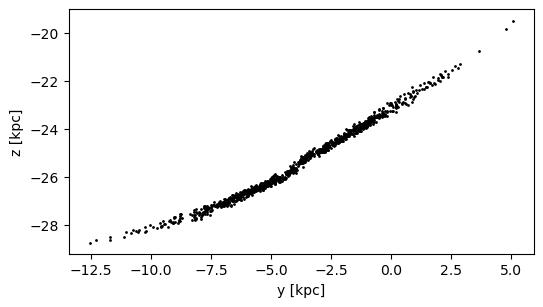

In [22]:
fig, ax = plt.subplots(1, 1, dpi=100)
fig.set_size_inches(6, 6)
ax.scatter(stream_unperturb['part_xv'][:, 1], stream_unperturb['part_xv'][:, 2], s=1, rasterized=True, color='k')
ax.set_xlabel('y [kpc]')
ax.set_ylabel('z [kpc]')
# ax.set_xlim(-10,10)
# ax.set_ylim(17,21)
ax.set_aspect('equal')

In [23]:
%%time
phi1_unperturb, phi2_unperturb = ssf.generate_stream_coords(stream_unperturb['part_xv'], xv_prog=prog_wtoday, optimizer_fit=False,) 

CPU times: user 839 μs, sys: 0 ns, total: 839 μs
Wall time: 744 μs


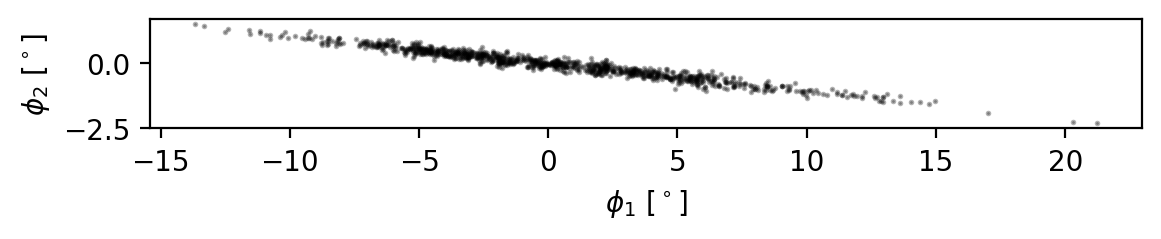

In [25]:
fig, ax = plt.subplots(1, 1, dpi=200)
ax.scatter(phi1_unperturb, phi2_unperturb, s=1, alpha=0.3, color='k')
ax.set_xlabel(r'$\phi_1 \ [^\circ]$')
ax.set_ylabel(r'$\phi_2 \ [^\circ]$')
# ax.set_xlim(-10,10)
# ax.set_ylim(17,21)
ax.set_aspect('equal')

# <span style="color:blue"> Let's figure out the interaction Geometry </span>

In [26]:
from typing import Dict, Any
import numpy as np

def get_subhalo_impact_w(
    w_p_impact: np.ndarray,
    b: float,
    v_rel_para: float,
    v_rel_perp: float,
    psi: float = 0.0,
    theta: float = 90.0
) -> np.ndarray:
    """
    Computes the phase-space position of a subhalo at the moment of impact 
    using a stream-centric coordinate system.
    
    The coordinate frame is defined by:
    - e1: parallel to the stream particle's velocity (flow direction)
    - e3: perpendicular to the orbital plane (angular momentum direction)
    - e2: completes the right-handed basis (e2 = e3 × e1)
    
    Parameters
    ----------
    w_p_impact : np.ndarray, shape (6,)
        The 6D phase-space vector [x, y, z, vx, vy, vz] of the stream 
        particle at t_impact. 
        Units: [kpc, kpc, kpc, km/s, km/s, km/s]
    b : float
        Impact parameter (kpc). The perpendicular distance between the 
        subhalo and the stream particle at the moment of impact, measured
        in the plane perpendicular to the stream velocity.
    v_rel_para : float
        Relative velocity component parallel to the stream flow (km/s).
        Positive means the subhalo is moving faster along the stream direction.
    v_rel_perp : float
        Magnitude of relative velocity component perpendicular to the stream 
        flow (km/s). The direction is specified by theta.
    psi : float, optional
        Azimuthal angle specifying the subhalo's position in the plane 
        perpendicular to the stream velocity (degrees).
        - psi = 0: offset in the e2 direction (L × V direction)
        - psi = 90: offset in the e3 direction (orbital normal)
        Default: 0.0 (this is alpha from Tri's paper.)
    theta : float, optional
        Azimuthal angle specifying the direction of perpendicular relative 
        velocity in the plane perpendicular to stream flow (degrees).
        - theta = 0: perpendicular velocity in e2 direction
        - theta = 90: perpendicular velocity in e3 direction
        Default: 90.0
    
    Returns
    -------
    w_sh : np.ndarray, shape (6,)
        6D phase-space vector [x, y, z, vx, vy, vz] of the subhalo at impact.
        Units: [kpc, kpc, kpc, km/s, km/s, km/s]
    
    Notes
    -----
    The geometry assumes a local linearized encounter where the impact 
    parameter b represents the minimum separation. The basis vectors are:
    - e1 = V / |V|  (stream flow direction)
    - e3 = L / |L|  (orbital angular momentum direction)
    - e2 = e3 × e1  (completes right-handed system)
    
    Examples
    --------
    >>> # Stream particle at impact: position and velocity
    >>> w_stream = np.array([8.0, 0.0, 0.1, 0.0, 220.0, 0.0])
    >>> # Subhalo passes 0.5 kpc away with 50 km/s relative velocity
    >>> w_subhalo = get_subhalo_impact_w(
    ...     w_stream, b=0.5, v_rel_para=30.0, v_rel_perp=40.0
    ... )
    """
    x_p = w_p_impact[:3]  # position in kpc
    v_p = w_p_impact[3:]  # velocity in km/s
    
    # Convert angles from degrees to radians
    psi_rad = np.deg2rad(psi)
    theta_rad = np.deg2rad(theta)
    
    # --- 1. Construct orthonormal basis ---
    # e1: Parallel to stream velocity (flow direction)
    e1 = v_p / np.linalg.norm(v_p) 
    
    # e3: Normal to the orbital plane (angular momentum direction)
    L = np.cross(x_p, v_p)
    e3 = L / np.linalg.norm(L)     
    
    # e2: Completes right-handed basis, perpendicular to both
    e2 = np.cross(e3, e1)          
    
    # --- 2. Calculate subhalo position ---
    # Place subhalo at distance b in the perpendicular plane
    # Position offset: b * [cos(psi)*e2 + sin(psi)*e3]
    x_sh = x_p + b * (np.cos(psi_rad) * e2 + np.sin(psi_rad) * e3)
    
    # --- 3. Calculate subhalo velocity ---
    # Relative velocity has parallel and perpendicular components
    # v_sh = v_p + v_rel_para*e1 + v_rel_perp*[cos(theta)*e2 + sin(theta)*e3]
    v_parallel_vec = v_rel_para * e1
    v_perp_vec = v_rel_perp * (np.cos(theta_rad) * e2 + np.sin(theta_rad) * e3)
    v_sh = v_p + v_parallel_vec + v_perp_vec
    
    return np.concatenate([x_sh, v_sh])


def get_target_w_at_impact(
    stream_today_cart: np.ndarray, 
    stream_today_phi1: np.ndarray, 
    target_phi1: float, 
    delta_phi1: float,
    t_impact: float, 
    potential: Any
) -> np.ndarray:
    """
    Finds the phase-space position of a stream segment at the impact time
    by averaging particles in a specified phi1 range today and integrating
    backwards in time.
    
    Parameters
    ----------
    stream_today_cart : np.ndarray, shape (N, 6)
        Stream particles at present day (t=0) in Galactic Cartesian coordinates.
        Columns: [x, y, z, vx, vy, vz]
        Units: [kpc, kpc, kpc, km/s, km/s, km/s]
    stream_today_phi1 : np.ndarray, shape (N,)
        Corresponding phi1 coordinates of stream particles at present day.
        Units: degrees
    target_phi1 : float
        The phi1 coordinate (degrees) where the impact should occur in the
        present-day stream configuration. The function will find particles
        near this location and trace them back to t_impact.
    delta_phi1 : float
        The half-width (degrees) around target_phi1 to include in the average.
        Particles with |phi1 - target_phi1| < delta_phi1 are averaged.
    t_impact : float
        Time of impact (Gyr), measured relative to present day (t=0).
        Should be negative for impacts in the past (e.g., -1.0 for 1 Gyr ago).
    potential : Potential object
        Galactic potential (must have agama.orbit interface) used to 
        integrate the orbit backwards in time.
    
    Returns
    -------
    w_p_impact : np.ndarray, shape (6,)
        6D phase-space vector [x, y, z, vx, vy, vz] of the stream segment
        at the impact time t_impact.
        Units: [kpc, kpc, kpc, km/s, km/s, km/s]
    
    Notes
    -----
    The function performs two steps:
    1. Identifies stream particles within delta_phi1 of target_phi1 today
       and computes their average position/velocity
    2. Integrates this average state backwards from t=0 to t=t_impact
    
    If no particles are found within delta_phi1, the closest particle to
    target_phi1 is used instead.
    
    Examples
    --------
    >>> # Get stream position 1 Gyr ago at phi1 = -5 deg (today)
    >>> w_impact = get_target_w_at_impact(
    ...     stream_today_cart=stream_particles,
    ...     stream_today_phi1=phi1_coords,
    ...     target_phi1=-5.0,
    ...     delta_phi1=0.5,
    ...     t_impact=-1.0,  # 1 Gyr ago
    ...     potential=pot_mw
    ... )
    """
    # --- 1. Select and average particles near target_phi1 ---
    phi1_bool = np.isclose(stream_today_phi1, target_phi1, atol=delta_phi1)
    
    # If particles found, take mean; otherwise use closest particle
    if np.any(phi1_bool):
        avg_w_today = np.mean(stream_today_cart, axis=0, where=phi1_bool[:, None])
    else:
        # Fallback: use the single closest particle
        closest_idx = np.argmin(np.abs(stream_today_phi1 - target_phi1))
        avg_w_today = stream_today_cart[closest_idx]
    
    # --- 2. Integrate backwards to t_impact ---
    # Convert t_impact (Gyr) to integration time
    # For AGAMA: integrate from timestart=0 (today) to time=t_impact
    w_p_impact = agama.orbit(
        ic=avg_w_today, 
        potential=potential,  # Use the passed potential, not hardcoded potTotal
        trajsize=1,  # Only return final point
        time=t_impact,  # Target time (negative = past)
        timestart=0.0  # Start at present day
    )[1].flatten()
    
    return w_p_impact

def create_perturber_dict(
    stream_today_cart: np.ndarray,
    stream_today_phi1: np.ndarray,
    potential: Any,
    mass_perturber: float,
    scaleradius_perturber: float,
    impact_phi1: float,
    impact_time: float,
    impact_parameter: float,
    v_rel_parallel: float,
    v_rel_perpendicular: float,
    alpha_position: float = 0.0,
    alpha_velocity: float = 90.0,
    delta_phi1: float = 0.5
) -> Dict[str, Any]:
    """
    Create a perturber dictionary for stream-subhalo interaction simulations.
    
    This function computes the full 6D phase-space configuration of a subhalo
    at the time of impact with a stellar stream, given the impact geometry
    parameters. The resulting dictionary can be passed to stream simulation
    functions.
    
    Parameters
    ----------
    stream_today_cart : np.ndarray, shape (N, 6)
        Stream particles at present day in Galactic Cartesian coordinates.
        Units: [kpc, kpc, kpc, km/s, km/s, km/s]
    stream_today_phi1 : np.ndarray, shape (N,)
        Corresponding phi1 coordinates of stream particles at present day.
        Units: degrees
    potential : Potential object
        Galactic potential used to integrate orbits backwards in time.
    mass_perturber : float
        Mass of the perturbing subhalo. Units: Msun
    scaleradius_perturber : float
        Scale radius of the perturbing subhalo (NFW or Plummer profile).
        Units: kpc
    impact_phi1 : float
        The phi1 coordinate where the impact occurs in the present-day
        stream configuration. Units: degrees
    impact_time : float
        Time of impact relative to present day. Negative for past impacts.
        Units: Gyr
    impact_parameter : float
        Perpendicular distance between subhalo and stream at closest approach.
        Units: kpc
    v_rel_parallel : float
        Relative velocity component parallel to stream flow direction.
        Positive means subhalo overtakes stream, negative means lagging.
        Units: km/s
    v_rel_perpendicular : float
        Magnitude of relative velocity component perpendicular to stream flow.
        Must be non-negative. Units: km/s
    alpha_position : float, optional
        Azimuthal angle specifying subhalo position in the plane perpendicular
        to stream velocity. 0 corresponds to (L × V) direction. Units: degree
        Default: 0.0
    alpha_velocity : float, optional
        Azimuthal angle specifying direction of perpendicular relative velocity.
        Units: degree. Default: 90.0
    delta_phi1 : float, optional
        Half-width around impact_phi1 for averaging stream particles.
        Units: degrees. Default: 0.5
    
    Returns
    -------
    perturber_dict : dict
        Dictionary containing perturber parameters with keys:
        - 'mass': perturber mass (Msun)
        - 'scaleRadius': perturber scale radius (kpc)
        - 'w_subhalo_impact': 6D phase-space vector at impact (kpc, km/s)
        - 'time_impact': time of impact (Gyr)
    """
    # Get stream particle position/velocity at impact time
    w_stream_impact = get_target_w_at_impact(
        stream_today_cart=stream_today_cart,
        stream_today_phi1=stream_today_phi1,
        target_phi1=impact_phi1,
        delta_phi1=delta_phi1,
        t_impact=impact_time,
        potential=potential
    )
    
    # Compute subhalo position/velocity at impact using geometry
    w_subhalo_impact = get_subhalo_impact_w(
        w_p_impact=w_stream_impact,
        b=impact_parameter,
        v_rel_para=v_rel_parallel,
        v_rel_perp=v_rel_perpendicular,
        psi=alpha_position,
        theta=alpha_velocity
    )
    
    # Create perturber dictionary
    perturber_dict = {
        'mass': mass_perturber,
        'scaleRadius': scaleradius_perturber,
        'w_subhalo_impact': w_subhalo_impact,
        'time_impact': impact_time
    }
    
    return perturber_dict

In [28]:
%%time

# # first select a localized present-day phi1 location for the impact computation:
phi1_impact_today = -5 # deg in phi1 coords
delta_phi1_today = 0.5  # deg, basically some selected width to average out the posvel location

# # let's pick subhalo geometry parameters at the time of impact along with impact time:
time_impact = -0.25 # in Gyr
impact_parameter = 0.3 # kpc
v_rel_para, v_rel_perp = 10, 35 # km/s
angle_pos_at_impact, angle_vel_at_impact  = 0, 90.0 # in degree

# # finally pick subhalo potential profiles for NFW: mass, scaleradius
mass_perturber = 1e7 # in Msun
scaleradius_perturber = 0.3 # in kpc.

add_perturber = create_perturber_dict(
    stream_unperturb['part_xv'],
    phi1_unperturb,
    potTotal,
    mass_perturber,
    scaleradius_perturber,
    phi1_impact_today,
    time_impact,
    impact_parameter,
    v_rel_para,
    v_rel_perp,
    angle_pos_at_impact,
    angle_vel_at_impact,
    delta_phi1=0.5,
)

# Test out a particle-spray simulation
stream_perturb = ssf.create_stream_particle_spray(
    pot_host=potTotal, 
    initmass=prog_mass, 
    scaleradius=prog_scaleradius, 
    prog_pot_kind='Plummer', 
    sat_cen_present=prog_wtoday, 
    num_particles=num_particles,
    time_end=0.0, 
    time_total=Age_stream_inGyr, save_rate=1,
    add_perturber=add_perturber, verbose=True,
)

Adding a perturber on a self-consistent orbit with mass: 1.00e+07.
CPU times: user 11.5 s, sys: 196 ms, total: 11.7 s
Wall time: 56.6 ms


1000 orbits complete (100000 orbits/s)


In [29]:
%%time
phi1_perturb, phi2_perturb = ssf.generate_stream_coords(stream_perturb['part_xv'], xv_prog=prog_wtoday, optimizer_fit=True,) 

CPU times: user 1.64 ms, sys: 0 ns, total: 1.64 ms
Wall time: 1.52 ms


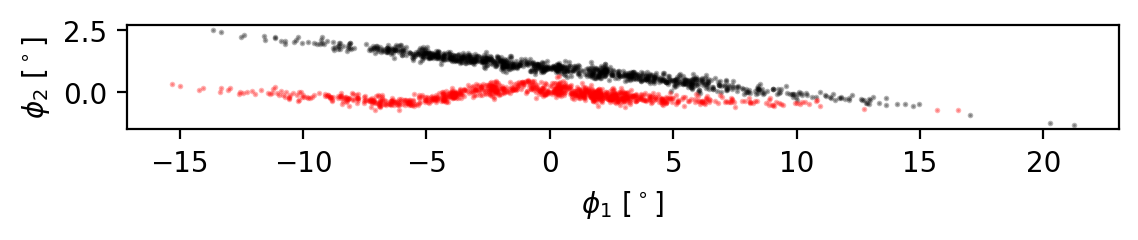

In [30]:
fig, ax = plt.subplots(1, 1, dpi=200)

ax.scatter(phi1_unperturb, phi2_unperturb+1, s=1, alpha=0.3, color='k', rasterized=True)
ax.scatter(phi1_perturb, phi2_perturb, s=1, alpha=0.3, color='r', rasterized=True)

ax.set_xlabel(r'$\phi_1 \ [^\circ]$')
ax.set_ylabel(r'$\phi_2 \ [^\circ]$')
# ax.set_xlim(-10,10)
# ax.set_ylim(17,21)
ax.set_aspect('equal')